In [ ]:
import pandas as pd

#for regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#for evaluation
from sklearn.metrics import mean_squared_error

#for saving the model
import pickle, os

In [ ]:
# Step 1–3: Load, merge, compute
df_info = pd.read_csv("order_info.csv")
df_details = pd.read_csv("order_line.csv")
df_details['Price per Unit'] = pd.to_numeric(df_details['Price per Unit'], errors='coerce')
df_details['Quantity'] = pd.to_numeric(df_details['Quantity'], errors='coerce')
df = pd.merge(df_info, df_details, on='Order ID')
df.dropna(subset=['Price per Unit', 'Quantity'], inplace=True)
df['Order Value'] = df['Price per Unit'] * df['Quantity']

In [3]:
# Step 4: Prepare final dataset
totals = df.groupby('Order ID')['Order Value'].sum().reset_index()
data = pd.merge(df_info, totals, on='Order ID')[['Customer Age', 'Customer Gender', 'Order Value']]
data['Customer Gender'] = data['Customer Gender'].map({'Female': 0, 'Male': 1})
data.dropna(inplace=True)

In [4]:
# Step 5–6: Split
X = data[['Customer Age', 'Customer Gender']]
y = data['Order Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 7: Train 
models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=10, random_state=42),
    "GradientBoost": GradientBoostingRegressor(n_estimators=10, random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(n_neighbors=min(5, len(X_train)))
}

best_model, lowest_mse = None, float('inf')
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"{name} MSE: {mse:.2f}")
    if mse < lowest_mse:
        best_model, lowest_mse = model, mse

Linear MSE: 17434891.34
RandomForest MSE: 17827130.87
GradientBoost MSE: 17418925.77
SVR MSE: 18250687.34
KNN MSE: 21564471.85


In [6]:
# Step 8: Save best model
with open("best_regression_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print(f"\nBest model saved with MSE: {lowest_mse:.2f}")


Best model saved with MSE: 17418925.77


In [ ]:
# Step 9: Predict 
def predict_order_value(age, gender):
    if not os.path.exists("best_regression_model.pkl"):
        return "Model file not found."
    with open("best_regression_model.pkl", "rb") as f:
        model = pickle.load(f)
    gender = {'Female': 0, 'Male': 1}.get(gender.capitalize())
    if gender is None:
        return "Invalid gender input."
    input_df = pd.DataFrame([[age, gender]], columns=['Customer Age', 'Customer Gender'])
    return float(model.predict(input_df)[0])

In [8]:
# Step 10: Run prediction
try:
    age_input = int(input("Enter customer age: "))
    gender_input = input("Enter gender (Male/Female): ")
    result = predict_order_value(age_input, gender_input)
    print(f"Predicted Order Value: {result:.2f}")
except Exception as e:
    print("Error:", e)

Enter customer age:  32
Enter gender (Male/Female):  female


Predicted Order Value: 5666.27


In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta

# For Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture

# For Evaluation
from sklearn.metrics import silhouette_score

# For Saving the model
import joblib
import warnings

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [10]:
# Step 1: Sample Data
df_info = pd.read_csv("order_info.csv")
df_details = pd.read_csv("order_line.csv")

In [11]:
# Step 2: Merge and basic preprocessing
df = pd.merge(df_info, df_details, on='Order ID')
df['Date'] = pd.to_datetime(df['Date'])
df['TotalPrice'] = df['Quantity'] * df['Price per Unit']

In [12]:
# Step 3: RFM features + demographics
snap = df['Date'].max() + timedelta(days=1)
customer_df = df.groupby('Customer ID').agg({
    'Date': lambda x: (snap - x.max()).days,
    'Order ID': 'nunique',
    'TotalPrice': 'sum',
    'Customer Age': 'first',
    'Customer Gender': 'first'
}).reset_index().rename(columns={
    'Date': 'Recency', 'Order ID': 'Frequency',
    'TotalPrice': 'Monetary', 'Customer Age': 'Age'
})

In [13]:
# Step 4: Encoding + scaling
num_cols = ['Recency', 'Frequency', 'Monetary', 'Age']
cat_cols = ['Customer Gender']
X = customer_df.drop('Customer ID', axis=1)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

X_proc = preprocessor.fit_transform(X)

In [14]:
# Step 5: Clustering models
models = {
    'KMeans': KMeans(n_clusters=4, random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=4),
    'DBSCAN': DBSCAN(eps=1.2, min_samples=2),
    'Gaussian': GaussianMixture(n_components=4, random_state=42),
    'BIRCH': Birch(n_clusters=4)
}

scores = {}
for name, model in models.items():
    labels = model.fit_predict(X_proc)
    scores[name] = silhouette_score(X_proc, labels) if len(set(labels)) > 1 else -1

best = max(scores, key=scores.get)
best_model = models[best]
joblib.dump(best_model, 'best_clustering_model.joblib')
joblib.dump(preprocessor, 'data_preprocessor_clustering.joblib')

['data_preprocessor_clustering.joblib']

            Recency          Frequency              Monetary            \
               mean min  max      mean min max          mean       min   
Cluster                                                                  
0         49.577181   1  173  5.369128   1   9  28526.374732   2694.86   
1         37.435424   1  148  9.254613   6  16  56083.621255  28305.47   
2         47.853211   1  152  5.504587   1  10  29321.221284    731.86   
3        190.846154  98  345  3.317308   1   9  17785.882308     96.50   

                          Age Customer ID  
               max       mean       count  
Cluster                                    
0         54696.09  28.429530         298  
1        122946.31  41.590406         271  
2         59846.48  54.214067         327  
3         58316.73  40.596154         104  


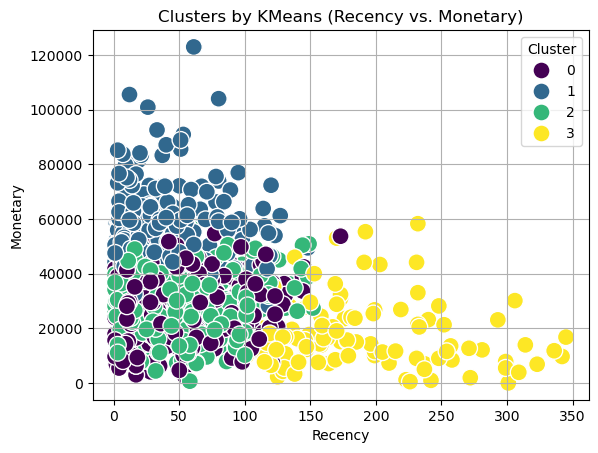

In [15]:
# Step 6: Final labeling + plotting
customer_df['Cluster'] = best_model.fit_predict(X_proc)
summary = customer_df.groupby('Cluster').agg({
    'Recency': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max'],
    'Age': 'mean',
    'Customer ID': 'count'
})

print(summary)

sns.scatterplot(data=customer_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=150)
plt.title(f'Clusters by {best} (Recency vs. Monetary)')
plt.grid(True)
plt.show()